<a href="https://colab.research.google.com/github/Yo-niung/SMUSW2025/blob/main/0923sw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 511kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Epoch [1/10], Loss: 0.0021
Epoch [2/10], Loss: 0.0012
Epoch [3/10], Loss: 0.0008
Epoch [4/10], Loss: 0.0009
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0003

Training finished!

Displaying test results...


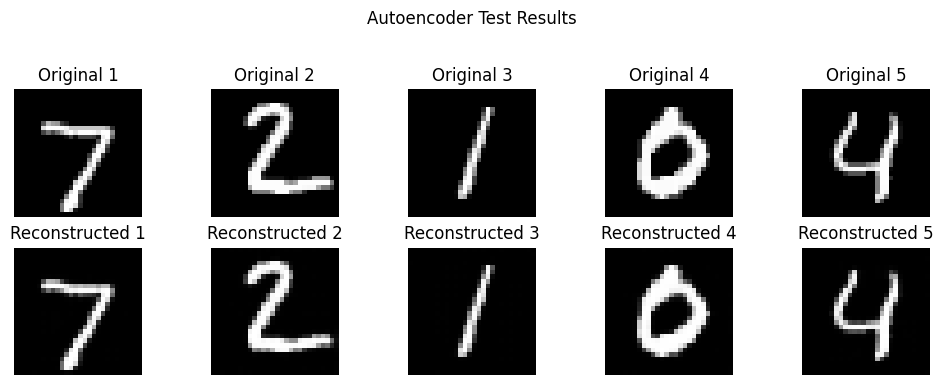

In [1]:
# 1. 라이브러리 임포트
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

# 2. 모델 정의 (Encoder & Decoder)
# Encoder 정의
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # batch_size를 유지하기 위해 out.size(0) 사용
        return out

# Decoder 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
            nn.Sigmoid() # 출력을 0~1 사이로 정규화
        )

    def forward(self, x):
        out = x.view(x.size(0), 256, 7, 7) # batch_size를 유지하기 위해 x.size(0) 사용
        out = self.layer1(out)
        out = self.layer2(out)
        return out

# 3. 데이터 로딩 & 데이터 로더 설정
batch_size = 100
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# 4. 초기 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)
parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=0.001)

# 5. 훈련
num_epoch = 10
for i in range(num_epoch):
    for j, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)

        z = encoder(image)
        output = decoder(z)

        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{i+1}/{num_epoch}], Loss: {loss.item():.4f}")

print("\nTraining finished!\n")


# 6. 훈련 후 테스트 결과 출력
print("Displaying test results...")
encoder.eval()
decoder.eval()

with torch.no_grad():
    for j, [image, label] in enumerate(test_loader):
        image = image.to(device)
        z = encoder(image)
        output = decoder(z)

        fig, axes = plt.subplots(2, 5, figsize=(10, 4))
        fig.suptitle("Autoencoder Test Results")

        for k in range(5):
            # 원본 이미지
            axes[0, k].imshow(torch.squeeze(image[k]).cpu().numpy(), cmap='gray')
            axes[0, k].set_title(f'Original {k+1}')
            axes[0, k].axis('off')

            # 복원된 이미지
            axes[1, k].imshow(torch.squeeze(output[k]).cpu().numpy(), cmap='gray')
            axes[1, k].set_title(f'Reconstructed {k+1}')
            axes[1, k].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        if j == 0:
            break